In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

# --- CONFIGURATION ---
POPULATION_DATA_PATH = "../data/rewari_village_population_2011.csv"
GEOGRAPHY_DATA_PATH = "../data/rewari_boundary.geojson"

# --- LOAD DATA ---
print("Loading datasets...")
# Load village population data
df_population = pd.read_csv(POPULATION_DATA_PATH)

# Load the district boundary
gdf_district = gpd.read_file(GEOGRAPHY_DATA_PATH)

print("Datasets loaded successfully.")

# --- VERIFICATION ---
print("\nDistrict Boundary Info:")
gdf_district.info()

print("\nPopulation Data Info:")
df_population.info()

print("\nFirst 5 villages:")
display(df_population.head())

Loading datasets...
Datasets loaded successfully.

District Boundary Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_2      1 non-null      object  
 1   GID_0      1 non-null      object  
 2   COUNTRY    1 non-null      object  
 3   GID_1      1 non-null      object  
 4   NAME_1     1 non-null      object  
 5   NL_NAME_1  1 non-null      object  
 6   NAME_2     1 non-null      object  
 7   VARNAME_2  1 non-null      object  
 8   NL_NAME_2  1 non-null      object  
 9   TYPE_2     1 non-null      object  
 10  ENGTYPE_2  1 non-null      object  
 11  CC_2       1 non-null      object  
 12  HASC_2     1 non-null      object  
 13  geometry   1 non-null      geometry
dtypes: geometry(1), object(13)
memory usage: 244.0+ bytes

Population Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data c

,loc_code,village_name,total_households,total_population
0,62518,Gangoli(135),235.0,5.0
1,62519,Saharanwas (130),174.0,462.0
2,62520,Ladhuwas Ahir (129),171.0,275.0
3,62521,Khargwas (127),233.0,252.0
4,62522,Balawas Ahir (128),163.0,322.0


Populating the world with agents...
Population complete. Created 7075 agents in 20 villages.
Preparing visualization...


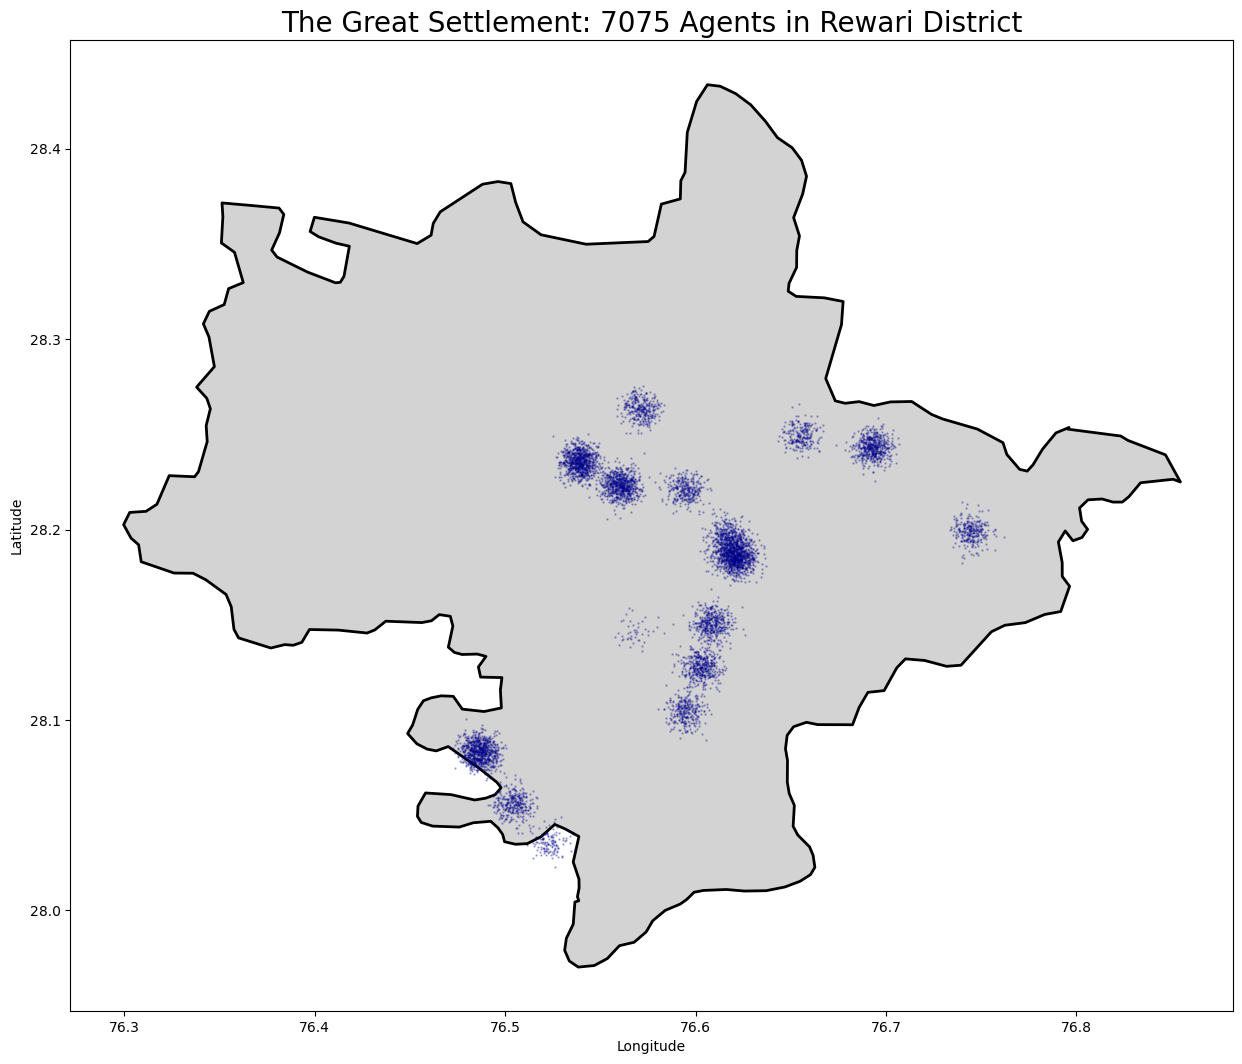

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import time

# --- CONFIGURATION ---
GEOCODED_DATA_PATH = "../data/rewari_villages_geocoded.csv"
GEOGRAPHY_DATA_PATH = "../data/rewari_boundary.geojson"

# --- CLASS DEFINITIONS ---

class Agent:
    """A simple class to represent an individual person in our simulation."""
    def __init__(self, agent_id, home_village, x, y):
        self.id = agent_id
        self.home_village = home_village
        self.x = x
        self.y = y
        # We will add more attributes like health status (S, I, R) later.
    
    def __repr__(self):
        return f"Agent(id={self.id}, village='{self.home_village}', pos=({self.x:.4f}, {self.y:.4f}))"

class World:
    """A class to manage the simulation environment, agents, and geography."""
    def __init__(self, district_geography, village_data):
        self.gdf_district = district_geography
        self.df_villages = village_data
        self.agents = []
        
        # Handle villages that could not be geocoded
        self.villages_to_process = self.df_villages.dropna(subset=['latitude', 'longitude']).copy()
        missing_count = len(self.df_villages) - len(self.villages_to_process)
        if missing_count > 0:
            print(f"Warning: Could not find coordinates for {missing_count} villages. They will be excluded for now.")

    def populate(self):
        """Creates agent objects for the entire population and places them near their home village."""
        print("Populating the world with agents...")
        agent_id_counter = 0
        
        # A small radius for scattering agents around a village center (in degrees longitude/latitude)
        # This prevents all agents from being in a single spot.
        spread_radius = 0.005 

        for _, village in self.villages_to_process.iterrows():
            village_pop = int(village['total_population'])
            village_name = village['village_name']
            village_lat = village['latitude']
            village_lon = village['longitude']
            
            for _ in range(village_pop):
                # Add a small random "noise" to the village coordinates for realistic clustering
                agent_x = village_lon + np.random.normal(0, spread_radius)
                agent_y = village_lat + np.random.normal(0, spread_radius)
                
                self.agents.append(
                    Agent(
                        agent_id=agent_id_counter,
                        home_village=village_name,
                        x=agent_x,
                        y=agent_y
                    )
                )
                agent_id_counter += 1
        
        print(f"Population complete. Created {len(self.agents)} agents in {len(self.villages_to_process)} villages.")

    def visualize(self):
        """Creates a plot of the district and all agents."""
        print("Preparing visualization...")
        
        agent_x = [agent.x for agent in self.agents]
        agent_y = [agent.y for agent in self.agents]

        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        
        self.gdf_district.plot(ax=ax, facecolor='lightgray', edgecolor='black', linewidth=2)
        ax.scatter(agent_x, agent_y, s=0.5, color='darkblue', alpha=0.3)

        ax.set_title(f"The Great Settlement: {len(self.agents)} Agents in Rewari District", fontsize=20)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_aspect('equal', adjustable='box')
        plt.show()

# --- MAIN EXECUTION ---

# 1. Load the data
df_population = pd.read_csv(GEOCODED_DATA_PATH)
gdf_district = gpd.read_file(GEOGRAPHY_DATA_PATH)

# 2. Create the World
my_world = World(gdf_district, df_population)

# 3. Populate the World with Agents
my_world.populate()

# 4. Visualize the result
my_world.visualize()

In [11]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd

# --- LOAD CORRECTED DATA ---
POPULATION_DATA_PATH = "../data/rewari_village_population_2011_main.csv"
df_population = pd.read_csv(POPULATION_DATA_PATH)

# --- SETUP GEOCODER ---
# We identify ourselves with a user_agent. You can change this to your app's name.
geolocator = Nominatim(user_agent="aetheria_h_simulation")

# We use a rate limiter to avoid overwhelming the free geocoding service (1 request per second)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# --- GEOCODING FUNCTION ---
def get_coords(row):
    # We create a specific query for higher accuracy
    query = f"{row['village_name']}, Rewari, Haryana, India"
    print(f"Geocoding: {query}")
    location = geocode(query)
    if location:
        return pd.Series([location.latitude, location.longitude])
    else:
        return pd.Series([None, None])

# --- EXECUTE GEOCODING ---
# Apply the function to each row in our dataframe.
# This will take several minutes to run as it makes one request per second for ~389 villages.
df_population[['latitude', 'longitude']] = df_population.apply(get_coords, axis=1)

print("\n--- Geocoding Complete ---")
display(df_population.head())

# Save the enriched data
GEOCODED_CSV_PATH = "../data/rewari_villages_geocoded.csv"
df_population.to_csv(GEOCODED_CSV_PATH, index=False)
print(f"\nGeocoded village data saved to {GEOCODED_CSV_PATH}")

Geocoding: Gangoli(135), Rewari, Haryana, India
Geocoding: Saharanwas (130), Rewari, Haryana, India
Geocoding: Ladhuwas Ahir (129), Rewari, Haryana, India
Geocoding: Khargwas (127), Rewari, Haryana, India
Geocoding: Balawas Ahir (128), Rewari, Haryana, India
Geocoding: Jadara (87), Rewari, Haryana, India
Geocoding: Aaspur (114), Rewari, Haryana, India
Geocoding: Bhudpur (116), Rewari, Haryana, India
Geocoding: Lakhnor (115), Rewari, Haryana, India
Geocoding: Gindo Khar (113), Rewari, Haryana, India
Geocoding: Rajpura Khalsa (111), Rewari, Haryana, India
Geocoding: Kishangarh (110), Rewari, Haryana, India
Geocoding: (224), Rewari, Haryana, India
Geocoding: Gangayacha Ahir (222), Rewari, Haryana, India
Geocoding: Gangayacha Jatt(223), Rewari, Haryana, India
Geocoding: Bhurthal Jatt (216), Rewari, Haryana, India
Geocoding: Bhurthal Thethar (215), Rewari, Haryana, India
Geocoding: Jeetpur Shekhpur (260), Rewari, Haryana, India
Geocoding: Chillar (259), Rewari, Haryana, India
Geocoding: Jan

,loc_code,village_name,total_households,total_population,latitude,longitude
0,62518,Gangoli(135),235.0,5.0,NaN,NaN
1,62519,Saharanwas (130),174.0,462.0,NaN,NaN
2,62520,Ladhuwas Ahir (129),171.0,275.0,NaN,NaN
3,62521,Khargwas (127),233.0,252.0,NaN,NaN
4,62522,Balawas Ahir (128),163.0,322.0,28.223139,76.561156



Geocoded village data saved to ../data/rewari_villages_geocoded.csv
